# **CIS 5450 Final Project - Spotify Song Popularity Prediction**
Katherine Jia, Yemisi Jones

# Introduction & Background

The goal of this final project was to train a model to predict song popularity on Spotify using acoustic features. This problem stood out to us because we were interested in learning about what makes a song popular, which is likely also of interest to songwriters, producers, and stakeholders in music production companies. We selected a dataset `songs_df` that contains a variety of attributes, including energy, loudness, duration, and danceability, for over 200,000 songs on Spotify. Through our exploratory data analysis, we were able to gain insight into the correlation between various feature variables, as well as the correlation between various features and song popularity. Notably, the danceability of a song seems to be highly correlated with popularity, as well as acousticness, as can be seen from our scatterplots.

# Data Loading & Cleaning

In [ ]:
# Installs
!pip install pandasql
!pip install -U bayesian-optimization

In [ ]:
# Imports
import pandas as pd
import pandasql as ps
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV
from bayes_opt import BayesianOptimization

## Loading Spotify Data

We decided to download the [dataset](https://drive.google.com/file/d/1mts3GI7mozRauRKXVDkoSw5BCFc103p0/view?usp=sharing) from Kaggle and mount to the local Google Drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the kaggle directory
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download 'Spotify 1.2M+ Songs' dataset
!kaggle datasets download -d tomigelo/spotify-audio-features

 40% 7.00M/17.4M [00:00<00:00, 71.5MB/s]
100% 17.4M/17.4M [00:00<00:00, 96.5MB/s]


In [ ]:
# Unzip folder in Colab content folder
!unzip /content/spotify-audio-features.zip

Archive:  /content/spotify-audio-features.zip
  inflating: SpotifyAudioFeaturesApril2019.csv  
  inflating: SpotifyAudioFeaturesNov2018.csv  


In [ ]:
# Read the csv files into pandas dataframes 'songs_df_18' and 'songs_df_19'
songs_df_18 = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')
songs_df_19 = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')

## Preprocessing Spotify Data

### Joining Dataframes

In [ ]:
# View the first five rows of 'songs_df_18'
pd.set_option('display.max_columns', None)
songs_df_18.head(5)

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [ ]:
# View the first five rows of 'songs_df_19'
songs_df_19.head(5)

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,9
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,8


Observing the two dataframes, we can see that they have the exact same set of columns, and thus can be appended together vertically.

In [ ]:
# Concatenate dataframes together
songs_df = pd.concat([songs_df_18, songs_df_19], axis=0)

### Dropping Insignificant Columns and Null/Duplicate Rows

In [ ]:
# View first 10 rows of merged dataframe
songs_df.head(10)

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0
5,Curbo,26Y1lX7ZOpw9Ql3gGAlqLK,Debauchery - Original mix,0.001150,0.810,124016,0.417,0.919,9,0.1060,-10.783,0,0.0793,120.025,4,0.837,0
6,Bingo Play,5eIyK73BrxHLnly4F9PWqg,Grandma - Original mix,0.000539,0.819,132742,0.720,0.863,4,0.0727,-8.895,0,0.1510,124.003,4,0.934,0
7,G Herbo,13Mf2ZBpfNkgWJowvM5hXh,Bon appétit,0.115000,0.885,181838,0.348,0.000,9,0.1070,-12.569,1,0.4510,142.111,4,0.180,0
8,34 Feet,7BQaRTHk44DkMhIVNcXy2D,Among - Original mix,0.000058,0.740,124016,0.472,0.847,8,0.0959,-9.008,1,0.0551,120.034,4,0.622,0
9,Chris Cooq,049RxG2laEl9U1PGYeIqLV,Hazard - Original mix,0.000081,0.813,132742,0.731,0.910,11,0.0727,-8.932,1,0.0697,124.031,4,0.944,0


At first glance, we can see that the column `track_id` does not contain data that are particularly meaningful to us, so we can go ahead and drop it.

In [ ]:
# Dropping unnecessary columns
songs_df = songs_df.drop(columns={'track_id'})

We then drop all rows that contain NA values, checking that this does not substantially reduce the size of our dataset.

In [ ]:
# Number of rows in original dataframe
len(songs_df)

247035

In [ ]:
# Number of rows in dataframe with dropped NA rows
len(songs_df.dropna())

247033

In [ ]:
# Drop rows with any NA values (only 2)
songs_df = songs_df.dropna()

Finally, we drop all duplicate rows, checking that this does not substantially reduce the size of our dataset.

In [ ]:
# Number of rows in original dataframe
len(songs_df)

247033

In [ ]:
# Number of rows in dataframe with dropped duplicate rows
len(songs_df.drop_duplicates())

222135

In [ ]:
# Drop duplicate rows (24,719)
songs_df = songs_df.drop_duplicates()

### Handling Outliers

Potential outliers that could skew our data include songs that are significantly shorter or significantly longer than usual. Particularly short tracks, such as those that are under 20 seconds (20000 ms), are likely snippets, interludes, or sound effects, rather than full-length songs. On the other hand, extremely long tracks, such as those that are over 30 minutes (1800000 ms) are mostly recordings of concerts/performances or ASMR sounds. Since we are mainly interested in the popularity of individual songs, these outliers may skew our data, so we drop these rows.

In [ ]:
# Songs under 20 seconds
songs_df[songs_df['duration_ms'] < 20000]

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1863,Armin van Buuren,A State Of Trance (ASOT 863) - Intro XXL Guest...,0.0698,0.000,9870,0.6460,0.0000,10,0.4630,-12.541,0,0.000,0.000,0,0.000,0
2013,Ace Hood,Intro (Earth Strong),0.9190,0.783,15906,0.0918,0.0000,8,0.0924,-18.472,0,0.878,101.610,3,0.772,0
2329,A$AP ANT,#FREESHAKA INTRO,0.9230,0.702,15440,0.3930,0.1070,10,0.8210,-21.700,1,0.912,109.195,4,0.928,0
2998,Waka Flocka Flame,Tune-Up Man Skit (feat. Slim Dunkin),0.3660,0.000,14616,0.4060,0.0000,5,0.4270,-8.074,0,0.000,0.000,0,0.000,0
3511,Neil Young,Perry Como Rap - Live,0.4880,0.426,17067,0.2070,0.0451,7,0.1970,-30.465,1,0.755,138.017,3,0.260,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99720,Cast,I'll Wait For You - Dialogue,0.8580,0.718,19133,0.1280,0.0000,6,0.4370,-21.699,1,0.877,116.575,3,0.648,18
99722,Cast,Vows - Dialogue,0.7110,0.789,17933,0.2640,0.0000,0,0.2850,-23.195,0,0.952,92.748,4,0.169,18
99723,Cast,Fabulous French - Dialogue,0.8070,0.514,19493,0.7000,0.0000,7,0.7960,-11.251,1,0.724,101.590,5,0.863,17
99724,Cast,How Do You Hear It? - Dialogue,0.6060,0.000,14507,0.1300,0.0000,9,0.3550,-21.347,1,0.000,0.000,0,0.000,7


In [ ]:
# Songs over 30 minutes
songs_df[songs_df['duration_ms'] > 1800000]

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
5427,Excision,Lost Lands 2017 Mix,0.00164,0.467,4830606,0.94800,0.010300,1,0.4050,-1.929,1,0.2990,148.898,4,0.3170,41
5957,Franz Liszt,"Sonata in B Minor, S. 178",0.98900,0.290,1839520,0.09590,0.880000,6,0.0896,-22.171,1,0.0417,88.305,4,0.0378,2
27786,Monstercat,#194 - Monstercat: Call of the Wild (Hosted by...,0.00891,0.305,3627887,0.84700,0.002070,5,0.3720,-4.056,0,0.1540,174.016,4,0.2460,0
30268,Gentle Whispering,Fluffy Sleepy Whispers,0.09380,0.317,2097245,0.03080,0.000007,2,0.3370,-48.914,0,0.0852,115.481,3,0.0295,37
32375,White Sun,Eka Mai Recitation,0.97300,0.593,2105744,0.04980,0.007090,4,0.0862,-22.175,1,0.0441,83.000,4,0.1910,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95595,Grateful Dead,Playing In The Band - Live at Hec Edmundson Pa...,0.54700,0.453,2791933,0.46700,0.426000,9,0.9610,-12.002,0,0.0384,137.525,4,0.3900,34
104866,Rain Sounds,Rainy Journey With A Train,0.00150,0.207,3237000,0.54400,0.865000,1,0.5010,-25.356,1,0.0511,77.907,4,0.0942,3
104871,Rain Sounds,Rainforest & Animals,0.14200,0.259,2770500,0.71400,0.868000,1,0.4270,-23.169,1,0.1830,115.754,3,0.0293,10
104881,Rain Sounds,White Noise - 1 Hour,0.27700,0.000,3332195,0.00002,0.618000,8,0.9120,-22.417,0,0.0000,0.000,0,0.0000,8


In [ ]:
#Drop outlier rows
length_query = '''
SELECT *
FROM songs_df
WHERE duration_ms > 20000 AND duration_ms < 1800000
'''
length_df_sql = ps.sqldf(length_query, locals())
songs_df = length_df_sql

Another potential outlier pertains to the `speechiness` column--speechiness refers to how much spoken word is detected in the song. According to [this dataset card](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset), which describes a dataset that was also collected using Spotify's Web API, speechiness values above 0.66 likely describe tracks that are comprised entirely of spoken word. However, we noticed that many tracks with speechiness values between 0.66 and 0.85 are actually rap songs, so to allow for some margin of error and prevent unnecessary loss of data, we drop all songs with speechiness values over 0.85.

In [ ]:
# Songs with speechiness values over 0.85
songs_df[(songs_df['speechiness'] > 0.85)]

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
840,xJK.,Thrive,0.6760,0.484,178743,0.429,0.0515,0,0.411,-7.979,0,0.890,178.724,4,0.568,28
1944,Ace Hood,Ace Hood - Questions (Interlude),0.9110,0.705,36094,0.525,0.0000,11,0.451,-15.929,1,0.908,86.793,4,0.633,25
2630,Lud Foe,Intro,0.6210,0.701,99631,0.441,0.0000,8,0.689,-14.222,0,0.945,79.487,1,0.589,27
2648,Lud Foe,Interlude 1,0.9880,0.692,136777,0.393,0.0000,5,0.147,-13.552,0,0.930,94.806,4,0.727,25
7581,Paloma Faith,Evolution,0.7040,0.461,64867,0.438,0.0000,5,0.768,-15.591,1,0.897,68.602,4,0.327,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217146,JID,Frequency Change,0.4700,0.633,59118,0.506,0.0000,1,0.959,-16.808,1,0.863,70.128,4,0.784,60
217399,Vance Joy,Little Boy Intro - Live at Red Rocks Amphitheatre,0.7590,0.717,176590,0.578,0.0000,1,0.348,-8.820,1,0.918,69.345,4,0.338,35
217608,K$upreme,Gucci Cologne,0.0992,0.944,134428,0.444,0.0000,1,0.170,-10.367,1,0.922,129.888,4,0.312,60
219193,Logic,Grandpa's Space Ship,0.3040,0.629,122093,0.166,0.0000,1,0.161,-18.960,1,0.884,80.440,3,0.182,54


In [ ]:
#Drop outlier rows
speechiness_query = '''
SELECT *
FROM songs_df
WHERE speechiness <= 0.85
'''
speechiness_df_sql = ps.sqldf(speechiness_query, locals())
songs_df = speechiness_df_sql


### Further Cleaning

To make the `duration_ms` column easier for us to interpret, we convert the values from milliseconds to seconds and rename the column as `duration_s`. We do this without rounding in order to preserve the precision of our data.

In [ ]:
# Create column 'duration_s' (1 ms = 0.001 s)
duration_s_query = '''
SELECT *,
duration_ms * 0.001 AS duration_s
FROM songs_df
'''
duration_s_df_sql = ps.sqldf(duration_s_query, locals())
songs_df = duration_s_df_sql

In [ ]:
# Drop 'duration_ms'
songs_df = songs_df.drop(columns={'duration_ms'})

Per the previous [dataset card](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset), the values of `key` map to pitches using standard Pitch Class notation. We use this fact to convert `key` from integer to string in order to make the values more easily interpretable. Note that lowercase 's' signifies a sharp and lowercase 'f' signifies a flat.

In [ ]:
# Create dictionary mapping of keys from int to string
key_dict = {
    -1: None,
    0: 'C',
    1: 'Cs/Df',
    2: 'D',
    3: 'Ds/Ef',
    4: 'E',
    5: 'F',
    6: 'Fs/Gf',
    7: 'G',
    8: 'Gs/Ef',
    9: 'A',
    10: 'As/Bf',
    11: 'B',
}

In [ ]:
# Use dictionary to convert 'key' column to string
songs_df['key'] = songs_df['key'].map(key_dict)

# Exploratory Data Analysis

Before going into any data analaysis, we first define our key variables:
- `acousticness` measures from 0.0 to 1.0 whether the track is acoustic, with 1.0 signifying high confidence that the track is acoustic.
- `danceability` quantifies how suitable a track is for dancing based on tempo, rhythm stability, beat strength, and overall regularity. This is also a measure from 0.0 to 1.0; a danceability value of 1.0 is most danceable.
- `energy` quantifies the perceptual intensity and activity a track, with high energy tracks feeling fast, loud, and noisy. This is also a measure from 0.0 to 1.0.
- `instrumentalness` predicts whether a track contains no vocals, with "ooh" and "aah" sounds being treated as instrumental. This is also a measure from 0.0 to 1.0; an instrumentalness value of 1.0 signifies that the track likely contains no vocals.
- `liveness` descibes the presence of an audience in the recording. This is also a measure from 0.0 to 1.0, with values above 0.8 indicating strong likelihood that the track was performed live.
- `loudness` represents the overall loudness of the track in decibels (dB).
- `mode` indicates whether the track is in major key (1.0) or minor key (0.0).
- `speechiness` describes the presence of spoken word in the track. This is also a measure from 0.0 to 1.0, with values closer to 1.0 indicating that the track is more exclusively speech-like.
- `tempo` represents the overall estimated speed of a track in beats per minute (BPM).
- `time_signature` is the estimated time signature, which is a musical notation convention that describes how many beats are in each bar. This ranges from 3 to 7, indicating time signatures of 3/7 to 7/4.
- `valence` describes the positiveness conveyed in the track, with high valence tracks feeling and sounding more happy and cheerful. This is also a measure from 0.0 to 1.0.
- `popularity` is our target variable, representing the popularity of a track based mostly on the total number of plays and the recency of these plays. This is a measure from 0.0 to 100.0, with 100.0 being most popular.

Definitions are taken from [this dataset card](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

## Analyzing Data Structure

To familiarize ourselves with our data, we first examine the summary statistics of each column.

In [ ]:
# Descriptive statistics for each numeric column
songs_df.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,duration_s
count,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000,221312.000000
mean,0.339851,0.581141,0.570367,0.222501,0.193704,-9.905335,0.608200,0.109606,119.560400,3.883251,0.439141,25.468542,211.435119
std,0.344702,0.189589,0.259716,0.359311,0.166410,6.521075,0.488153,0.117063,30.079245,0.503259,0.258596,18.671894,96.348383
min,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.049000
25%,0.031100,0.459000,0.398000,0.000000,0.097400,-11.759000,0.000000,0.038800,96.017000,4.000000,0.224000,11.000000,164.969000
50%,0.200000,0.604000,0.605000,0.000149,0.123000,-7.923000,1.000000,0.055600,120.026000,4.000000,0.420000,23.000000,202.293000
75%,0.629000,0.726000,0.776000,0.427000,0.234000,-5.660000,1.000000,0.127000,139.792000,4.000000,0.637000,38.000000,241.098750
max,0.996000,0.996000,1.000000,1.000000,0.999000,1.806000,1.000000,0.850000,249.983000,5.000000,1.000000,100.000000,1796.800000


Some major takeaways:
- `instrumentalness`, `speechiness`, and `duration_s` seem to be extremely left-skewed.
- `popularity`, `acousticness`, `liveness`, and `valence` also seem to be left-skewed, but to a lesser extent.
- `time_signature` should be distributed across values from 3.0 to 7.0, but the minimum value is 0.0. Most of the values seem to be 4.0.

In [ ]:
# Datatypes of columns
songs_df.dtypes

artist_name          object
track_name           object
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
popularity            int64
duration_s          float64
dtype: object

Based on our observations of the spread of `time_signature`, we decide to drop this column. A time signature of 0.0 does not provide much specific information, and Spotify does not support higher time signatures like 9, 11, 13, or 17, making this data incomplete. In addition, we don't believe it will be a significant predictor of popularity.

In [ ]:
# Drop 'time_signature' column
songs_df = songs_df.drop(columns={'time_signature'})

We also noticed that there are some repeats in `artist_name`, so we want to know how many unique artists are represented in this dataset.

In [ ]:
# Number of unique values in 'artist_name'
len(songs_df['artist_name'].unique())

34583

Since `key` is now a categorical variable, for which we cannot compute summary statistics, we visualize its spread using a bar plot:

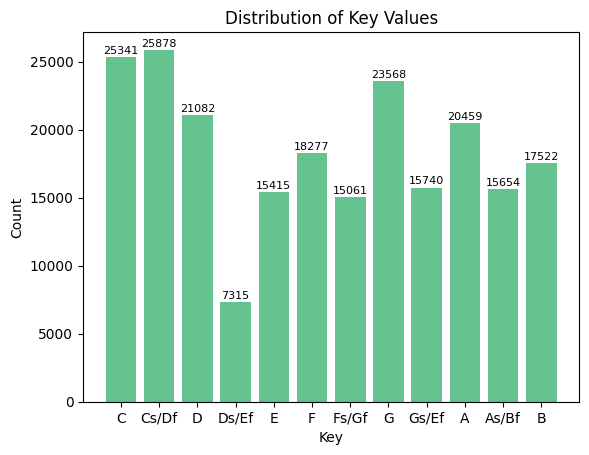

In [ ]:
# Get value counts of 'key' and order them
key_count_dict = songs_df['key'].value_counts()
scale_order = ['C', 'Cs/Df', 'D', 'Ds/Ef', 'E', 'F', 'Fs/Gf', 'G', 'Gs/Ef', 'A', 'As/Bf', 'B']
ordered_counts = [key_count_dict[key] for key in scale_order]
# Create bar plot + label axes
plt.bar(x=scale_order, height=ordered_counts, color=['mediumseagreen'], alpha=0.8)
plt.title('Distribution of Key Values')
plt.xlabel('Key')
plt.ylabel('Count')
# Label each bar with exact count
plt.text(0, ordered_counts[0] + 250, str(ordered_counts[0]), ha='center', fontsize=8)
plt.text(1, ordered_counts[1] + 250, str(ordered_counts[1]), ha='center', fontsize=8)
plt.text(2, ordered_counts[2] + 250, str(ordered_counts[2]), ha='center', fontsize=8)
plt.text(3, ordered_counts[3] + 250, str(ordered_counts[3]), ha='center', fontsize=8)
plt.text(4, ordered_counts[4] + 250, str(ordered_counts[4]), ha='center', fontsize=8)
plt.text(5, ordered_counts[5] + 250, str(ordered_counts[5]), ha='center', fontsize=8)
plt.text(6, ordered_counts[6] + 250, str(ordered_counts[6]), ha='center', fontsize=8)
plt.text(7, ordered_counts[7] + 250, str(ordered_counts[7]), ha='center', fontsize=8)
plt.text(8, ordered_counts[8] + 250, str(ordered_counts[8]), ha='center', fontsize=8)
plt.text(9, ordered_counts[9] + 250, str(ordered_counts[9]), ha='center', fontsize=8)
plt.text(10, ordered_counts[10] + 250, str(ordered_counts[10]), ha='center', fontsize=8)
plt.text(11, ordered_counts[11] + 250, str(ordered_counts[11]), ha='center', fontsize=8)

plt.show()

**Takeaway:** The most commonly used key in this dataset is C sharp/D flat, with C and G closely following. C sharp/D flat being the most common key is a bit surprising, as C and G are generally considered the best keys for pop music, although this dataset does contain songs from a wide variety of genres. D and A are next common, and then F and B, followed by G sharp/E flat, A sharp/B flat, E, and F sharp/G flat, with D sharp/E flat being the least common by a considerable margin. Overall, however, each key has enough data points (≥ 7315) that the performance of our model should not suffer.

Another variable whose distribution we are interested in is `duration_s`, as we observed a wide range of values during our cleaning process. Since there are 77,628 unique values in this column, we round to the nearest second in order to make the visualization a bit neater.

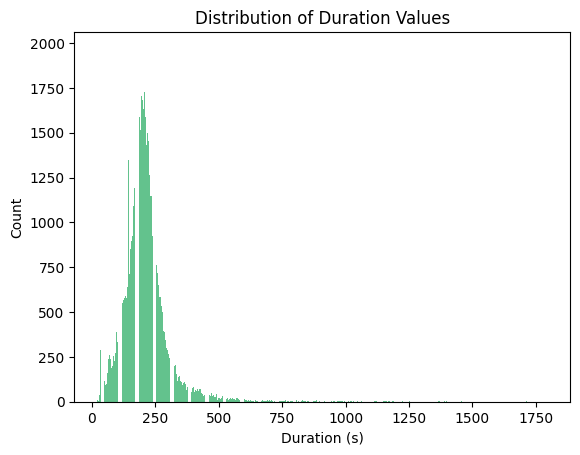

In [ ]:
# Get value counts of 'duration_s'
duration_counts = songs_df['duration_s'].round(decimals=0).value_counts()

# Create bar plot + label axes
plt.bar(x=duration_counts.index, height=duration_counts, color=['mediumseagreen'], alpha=0.8)
plt.title('Distribution of Duration Values')
plt.xlabel('Duration (s)')
plt.ylabel('Count')

plt.show()

**Takeaway:** The data seem to be centered around 210 seconds (3.5 minutes), which aligns with the average length of radio edit versions of songs, as well as the average length of a song on the Billboard Hot 100 in 2018, according to [Gitnux](https://gitnux.org/average-song-length/#:~:text=during%20that%20year.-,Radio%20edit%20versions%20of%20songs%20are%20typically%20around%203%20minutes,3%20minutes%20and%2030%20seconds.). It is clear that `duration_s` is extremely right-skewed, but we were reluctant to filter out too many longer songs, as many of them are classical pieces of considerable popularity, and we want to train our model on a wide variety of genres. However, linear regression assumes that the residual errors are normally distributed, so if this assumption is violated and our baseline model does not perform well, we might consider normalizing this variable or removing it entirely.

Another variable that we are interested in is `danceability`, as we predict that this will have a considerable impact on the popularity of a song. If a song is highly danceable, it is more likely to be played at parties, bars, clubs, etc., and it is probably more likely to go viral on social media platforms like Tiktok. We round the values to the thousandth place in order to make the visualization neater.

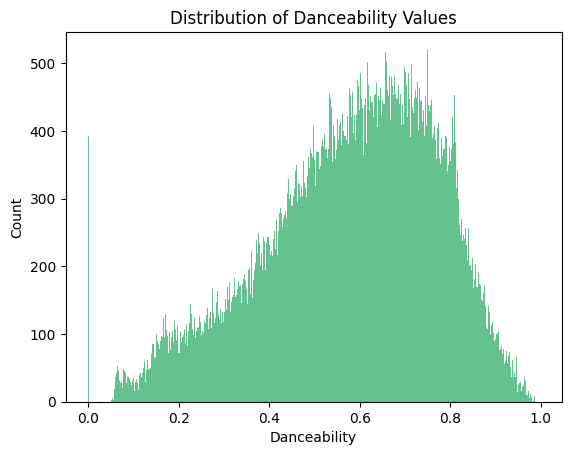

In [ ]:
# Get value counts of 'danceability'
danceability_counts = songs_df['danceability'].round(decimals=3).value_counts()
# Create bar plot + label axes
plt.bar(x=danceability_counts.index, height=danceability_counts, color=['mediumseagreen'], alpha=0.8, width=0.001)
plt.title('Distribution of Danceability Values')
plt.xlabel('Danceability')
plt.ylabel('Count')

plt.show()

**Takeway:** The data seem to be slightly left-skewed, with the values centering around 0.65, but overall it looks relatively normal. However, there are many outliers with danceability values of around 0.0. After taking a closer look at these songs, we noticed that many of these are ASMR/white noise tracks, which we are not interested in, so we filter out any tracks with `danceability` = 0.0 and whose `track_name` contains "Rain" or "Noise".

In [ ]:
# Songs with danceability of 0.0
songs_df[songs_df['danceability'] == 0]

,artist_name,track_name,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,duration_s
139,Armin van Buuren,A State Of Trance (ASOT 874) - Outro,0.02820,0.0,0.524000,0.000000,B,0.6580,-11.890,0,0.0,0.0,0.0,9,33.310
669,Johann Sebastian Bach,"Goldberg Variations, BWV 988 (Arr. for Accordi...",0.83600,0.0,0.136000,0.000158,G,0.0884,-15.614,1,0.0,0.0,0.0,3,127.347
12441,Pharm Sounds,Rain Forest Rain,0.00283,0.0,0.098100,0.992000,C,0.1580,-28.185,1,0.0,0.0,0.0,28,64.617
13251,Granular,One Start Trip,0.86500,0.0,0.000020,0.650000,Cs/Df,0.9440,-23.712,1,0.0,0.0,0.0,49,180.000
13615,Fan Sounds,Box Fan on High Long Loop,0.12300,0.0,0.000271,0.497000,Cs/Df,0.1610,-24.421,1,0.0,0.0,0.0,35,515.842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214843,Arx,Tranquil White Noise,0.00000,0.0,0.000000,0.000000,C,0.0000,-25.319,0,0.0,0.0,0.0,50,128.000
214943,Mattew10028,The hill on the lake,0.11100,0.0,0.000020,0.000000,Fs/Gf,0.1800,-51.420,0,0.0,0.0,0.0,53,64.260
217475,Brown Noise Baby,"Fan Noises for Sleeping (Looped, Loopable Fast...",0.49500,0.0,0.002430,0.261000,G,0.1200,-18.795,1,0.0,0.0,0.0,57,75.000
220100,Anthem Lights,We Three Kings / God Rest Ye Merry Gentlemen,0.71400,0.0,0.324000,0.000000,A,0.2910,-7.517,1,0.0,0.0,0.0,35,131.262


In [ ]:
# Remove outlier rows

songs_df = songs_df[~((songs_df['danceability'] == 0) & (songs_df['track_name'].str.contains('Noise')))]
songs_df = songs_df[~((songs_df['danceability'] == 0) & (songs_df['track_name'].str.contains('Rain')))]

Finally, we want to examine the distribution of `popularity`, to check for any imbalance/skewness.

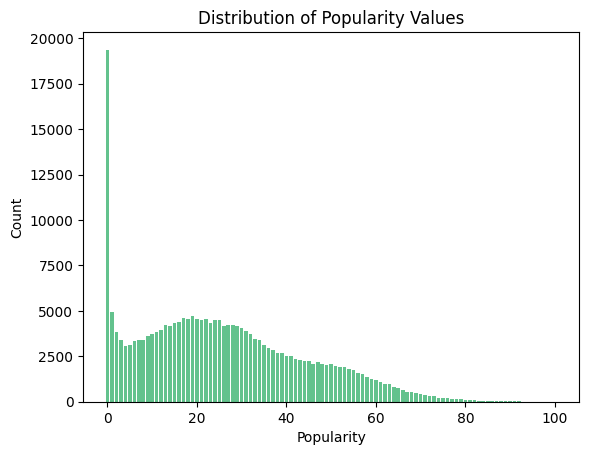

In [ ]:
# Get value counts of 'popularity'
popularity_counts = songs_df['popularity'].value_counts()
# Create bar plot + label axes
plt.bar(x=popularity_counts.index, height=popularity_counts, color=['mediumseagreen'], alpha=0.8)
plt.title('Distribution of Popularity Values')
plt.xlabel('Popularity')
plt.ylabel('Count')

plt.show()

**Takeway:** The data seem to be slightly right-skewed, with a substantial number of outliers at 0.0. Other than this, however, the distribution does not seem too imbalanced, and we may not need to utilize oversampling/undersampling, although it is something we may consider after observing the performance of our baseline model. The sheer number of songs with popularity values of 0.0 may simply be due to the fact that these songs are not appealing to the majority of Spotify users. However, another likely explanation is that these artists simply do not have the resources to promote their songs; many of these songs may have the potential to become extremely popular and may have audio features similar to more popular songs, but they just never reach a large enough audience to take off. These outliers may impact the performance of our model, and we should consider addressing them in our second round of feature engineering/preprocessing.

## Identifying Correlated Features

In this section, we investigate relationships between various feature variables that we believe may be correlated. The first pair of variables that are likely correlated are `instrumentalness` and `speechiness`. Based on the definitions of these variables (`instrumentalness` predicts whether a track contains no vocals and `speechiness` detects the presence of spoken words), we assume that they should be inversely proportional, as the more instrumental a track is, the less likely it is that the track contains spoken words.

correlation: -0.557935173199033


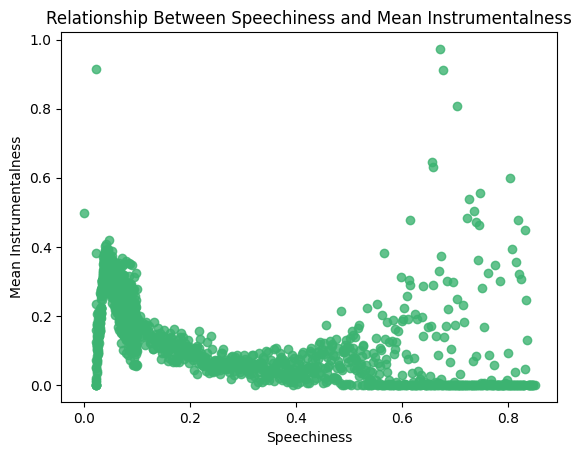

In [ ]:
# Calculate mean instrumentalness for each unique value of speechiness
speechiness_instrumentalness_mean_query = '''
SELECT speechiness, AVG(instrumentalness) AS instrumentalness
FROM songs_df
GROUP BY speechiness
'''
speechiness_instrumentalness_mean = ps.sqldf(speechiness_instrumentalness_mean_query, locals())

# Create scatter plot + label axes
plt.scatter(speechiness_instrumentalness_mean['speechiness'], speechiness_instrumentalness_mean['instrumentalness'], color=['mediumseagreen'], alpha=0.8)
plt.title('Relationship Between Speechiness and Mean Instrumentalness')
plt.xlabel('Speechiness')
plt.ylabel('Mean Instrumentalness')
# Compute and print correlation
correlation = speechiness_instrumentalness_mean['speechiness'].corr(speechiness_instrumentalness_mean['instrumentalness'])
print("correlation:", correlation)

plt.show()

**Takeaway:** Our assumption that the variables would be inversely correlated was correct, as the computed correlation value was approximately -0.568. However, the strength of this correlation was not as great as we predicted. In the scatterplot, between speechiness values of around 0.0-0.05, instrumentalness seems to rapidly increase with speechiness, then rapidly decreases after that, plateauing at around speechiness = 0.5. As speechiness increases toward values of 0.6-0.8, instrumentalness begins to vary widely. The irregularity of this relationship could be due to the fact that "ooh and "aah" sounds are treated as instrumental when computing instrumentalness, but they are treated as spoken word when computing speechiness.

Another pair of variables that could be correlated is `energy` and `loudness`, as high-energy tracks are described as feeling loud and noisy. Thus, we assume that they should be directly proportional.

correlation: 0.8701986721015591


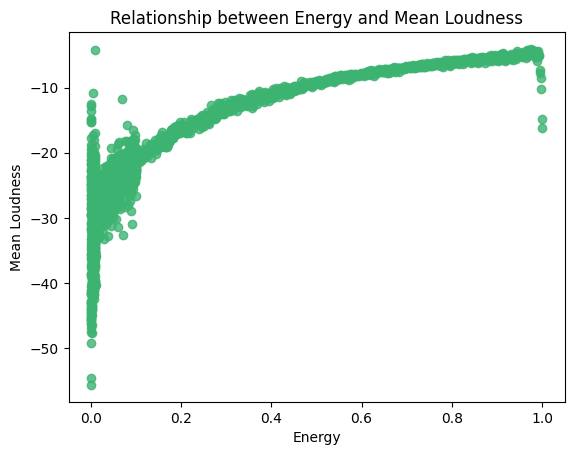

In [ ]:
# Calculate mean loudness for each unique value of energy
energy_loudness_mean_query = '''
SELECT energy, AVG(loudness) AS loudness
FROM songs_df
GROUP BY energy
'''
energy_loudness_mean = ps.sqldf(energy_loudness_mean_query, locals())
# Create scatter plot + label axes
plt.scatter(energy_loudness_mean['energy'], energy_loudness_mean['loudness'], color=['mediumseagreen'], alpha=0.8)
plt.title('Relationship between Energy and Mean Loudness')
plt.xlabel('Energy')
plt.ylabel('Mean Loudness')
# Compute and print correlation
correlation = energy_loudness_mean['energy'].corr(energy_loudness_mean['loudness'])
print("correlation:", correlation)

plt.show()

**Takeaway:** Our assumption that the variables would be directly proportional was correct, as loudness tends to increase with energy. The rate of increase of loudness does get slower as energy increases, which makes sense because there should be a cap on loudness at some point for the comfort and safety of the listener. In addition, when energy is around 0.0 there is high variation in loudness. This could be due to the fact that low-energy songs may still utilize loudness to create a certain musical effect or elicit an emotional response. The computed correlation value of around 0.870 indicates that the variables are highly correlated.

Another pair of variables that could be correlated is `valence` and `tempo`. Songs that we typically think of as upbeat and cheerful tend to be on the faster side, whereas songs that we typically think of as negative or melancholic tend to be on the slower side, so we assume that they should be directly proportional.

correlation: 0.4221041289138906


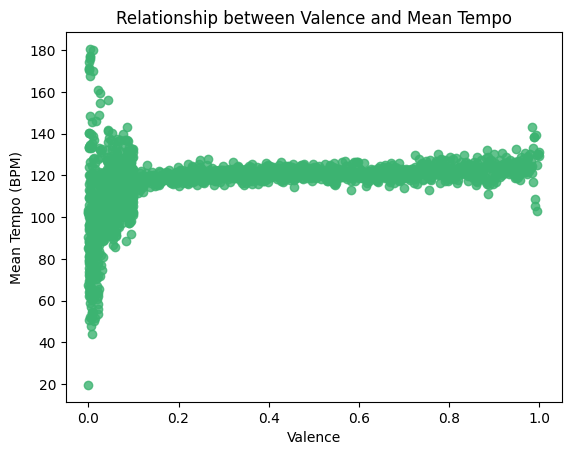

In [ ]:
# Calculate mean tempo for each unique value of valence
valence_tempo_mean_query = '''
SELECT valence, AVG(tempo) AS tempo
FROM songs_df
GROUP BY valence
'''
valence_tempo_mean = ps.sqldf(valence_tempo_mean_query, locals())
#valence_tempo_mean = songs_df.groupby('valence')['tempo'].mean().reset_index()
# Create scatter plot + label axes
plt.scatter(valence_tempo_mean['valence'], valence_tempo_mean['tempo'], color=['mediumseagreen'], alpha=0.8)
plt.title('Relationship between Valence and Mean Tempo')
plt.xlabel('Valence')
plt.ylabel('Mean Tempo (BPM)')
# Compute and print correlation
correlation = valence_tempo_mean['valence'].corr(valence_tempo_mean['tempo'])
print("correlation:", correlation)

plt.show()

**Takeaway:** Our assumption that the variables would be directly proportional does not seem to hold in this case, although we do observe an extremely slight upward trajectory in the data. Most tempo values seem to be centered around 120, regardless of valence. The data align with [MasterClass'](https://www.masterclass.com/articles/how-to-find-the-bpm-of-a-song) claim that "most of today's popular songs are written in a tempo range of 100 to 140 BPM" and "many songwriters consider 120 BPM to be the perfect tempo for crafting a hit." We also observe high variation in tempo when valence is around 0.0, which might be explained by the fact that different genres have different tempo ranges and use tempo differently. For example, many classical pieces use fast movements to create intense feelings of tension or unease. The computed correlation value of about 0.428 indicates relatively weak correlation between these variables.

Our exploration of the relationships between various variables in this dataset indicate that we have some correlated feature variables, which would decrease our model's performance. To remove redundant features, we plan on using Principal Component Analysis (PCA) in our feature engineering and preprocessing step.

## Visualizing Relationships Between Popularity & Various Features

In this section, we look at the correlation between different feature variables and popularity in order to gain a better sense of which features are more or less important in our prediction. The first feature we look at is `danceability`, which, as discussed in the 'Analyzing Data Structure' section, we believe will be positively correlated with popularity.

correlation: 0.9565863398356461


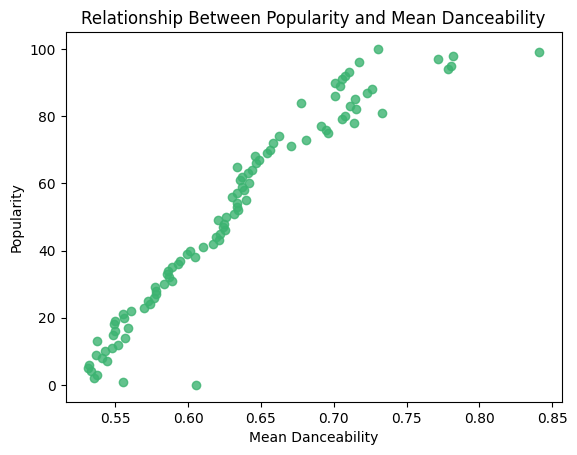

In [ ]:
# Calculate mean danceability for each unique value of popularity
popularity_danceability_mean_query = '''
SELECT popularity, AVG(danceability) AS danceability
FROM songs_df
GROUP BY popularity
'''
popularity_danceability_mean = ps.sqldf(popularity_danceability_mean_query, locals())
# Create scatterplot + label axes
plt.scatter(popularity_danceability_mean['danceability'], popularity_danceability_mean['popularity'], color='mediumseagreen', alpha=0.8)
plt.ylabel('Popularity')
plt.xlabel('Mean Danceability')
plt.title('Relationship Between Popularity and Mean Danceability')
# Compute and print correlation
correlation = popularity_danceability_mean['popularity'].corr(popularity_danceability_mean['danceability'])
print("correlation:", correlation)

plt.show()

**Takeaway:** Danceablility seems to have an extremely strong positive correlation with popularity, given the correlation value and the linear trend in the scatterplot. This means that songs with higher danceability scores are more likely to have higher popularity scores. As discussed before, this might be because highly danceable songs are more likely to be played at social events, bars, and clubs, as well as more likely to go viral on Tiktok and other social media sites. Given the magnitude of the correlation value, danceability is likely an important feature variable.

Another feature variable we are interested in is `energy`, which we believe could be positively correlated with popularity, as high-energy songs tend to be more catchy.

correlation: 0.6827277905673813


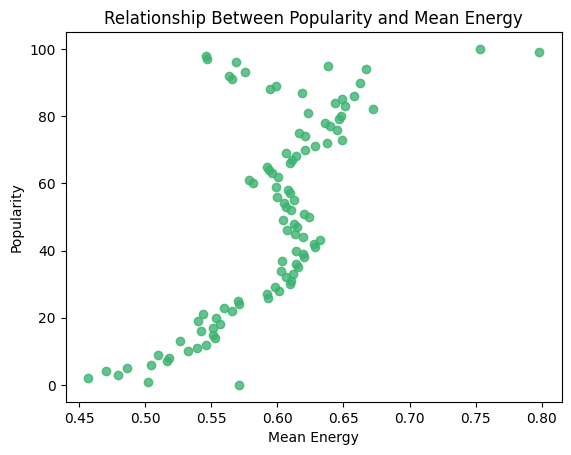

In [ ]:
# Calculate mean energy for each unique value of popularity
popularity_energy_mean_query = '''
SELECT popularity, AVG(energy) AS energy
FROM songs_df
GROUP BY popularity
'''
popularity_energy_mean = ps.sqldf(popularity_energy_mean_query, locals())
# Create scatterplot + label axes
plt.scatter(popularity_energy_mean['energy'], popularity_energy_mean['popularity'], color='mediumseagreen', alpha=0.8)
plt.ylabel('Popularity')
plt.xlabel('Mean Energy')
plt.title('Relationship Between Popularity and Mean Energy')
# Compute and print correlation
correlation = popularity_energy_mean['popularity'].corr(popularity_energy_mean['energy'])
print("correlation:", correlation)

plt.show()

**Takeaway:** Energy has a moderately strong positive correlation with popularity, given the correlation value and the shape of the data in the scatterplot. In the scatterplot, popularity increases with mean energy until about mean energy = 0.60, at which point it seems to stop increasing (excluding two outliers), indicating that the most high-energy songs are capped at values of around 0.60 to 0.65. The scatterplot also implies that most popular songs have "maximum" energy, but not all songs with "maximum" energy have high popularity. While energy is somewhat predictive of popularity, it may not be one of the most important feature variables, given the magnitude of the correlation value.

Another feature variable we want to investigate is `acousticness`. We haven't noticed many popular songs that are fully acoustic, so we assume that it is negatively correlated with popularity.

correlation: -0.8114497132459408


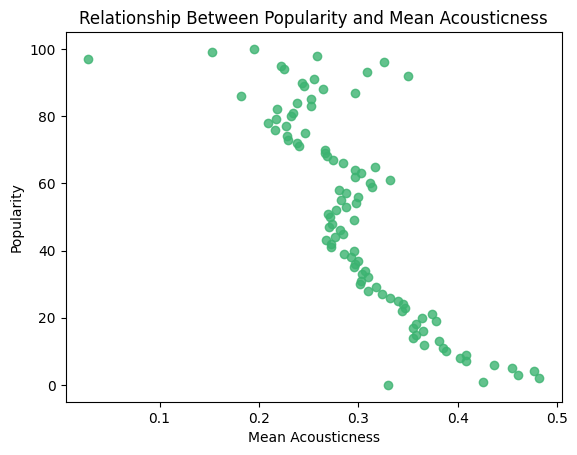

In [ ]:
# Calculate mean acousticness for each unique value of popularity
popularity_acousticness_mean_query = '''
SELECT popularity, AVG(acousticness) AS acousticness
FROM songs_df
GROUP BY popularity
'''
popularity_acousticness_mean =  ps.sqldf(popularity_acousticness_mean_query, locals())
# Create scatterplot + label axes
plt.scatter(popularity_acousticness_mean['acousticness'], popularity_acousticness_mean['popularity'], color='mediumseagreen', alpha=0.8)
plt.ylabel('Popularity')
plt.xlabel('Mean Acousticness')
plt.title('Relationship Between Popularity and Mean Acousticness')
# Compute and print correlation
correlation = popularity_acousticness_mean['popularity'].corr(popularity_acousticness_mean['acousticness'])
print("correlation:", correlation)

**Takeaway:** Acousticness has a reliably strong negative correlation with popularity, given the correlation value and the negative trend in the scatterplot. This means that songs with lower acousticness scores are more likely to have higher popularity scores. Aside from one outlier, highly popular songs seem to have mean acousticness values between 0.15 and 0.35, which may be something for songwriters and producers to consider. Given the magnitude of the correlation value, acousticness may be one of the more important feature variables.

Another feature variable to investigate is how many songs an artist has (in this dataset). We first create the column `artist_num_songs`, then visualize its relationship with popularity.

In [ ]:
# Compute column 'artist_num_songs' that contains the total number of songs (in this dataset) by the artist of the song
artist_counts_query = '''
WITH artist_counts AS (
    SELECT artist_name, COUNT(*) AS artist_num_songs
    FROM songs_df
    GROUP BY artist_name
)
SELECT songs_df.*, artist_counts.artist_num_songs
FROM songs_df
LEFT JOIN artist_counts ON songs_df.artist_name = artist_counts.artist_name
'''
songs_df = ps.sqldf(artist_counts_query, locals())


correlation: -0.7205192047048716


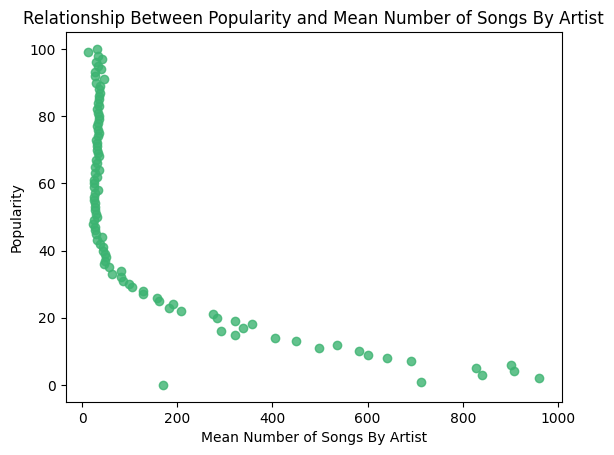

In [ ]:
# Calculate mean artist_num_songs value for each unique value of popularity
popularity_num_songs_mean_query = '''
SELECT popularity, AVG(artist_num_songs) AS artist_num_songs
FROM songs_df
GROUP BY popularity
'''
popularity_num_songs_mean = ps.sqldf(popularity_num_songs_mean_query, locals())
# Create scatterplot + label axes
plt.scatter(popularity_num_songs_mean['artist_num_songs'], popularity_num_songs_mean['popularity'], color='mediumseagreen', alpha=0.8)
plt.ylabel('Popularity')
plt.xlabel('Mean Number of Songs By Artist')
plt.title('Relationship Between Popularity and Mean Number of Songs By Artist')
# Compute and print correlation
correlation = popularity_num_songs_mean['popularity'].corr(popularity_num_songs_mean['artist_num_songs'])
print("correlation:", correlation)

**Takeaway:** The total number of songs (in this dataset) by the artist of a song has a moderately strong negative corelation with the popularity of that song. The most popular songs seem to be sung by artists that have around 50 total songs in this dataset, although not all songs by such artists have high popularity values. Popularity only decreases as the number of songs by the artist increases. This trend could be due to the fact that artists with higher numbers of songs are probably older, with classical musician Johann Sebastian Bach having the highest number of songs; while his music is extremely impactful, it might not be the most popular with the average Spotify user. Given the magnitude of the correlation value, `artist_num_songs` may be a relatively important feature variable.

# Feature Engineering & Data Preprocessing

Before beginning, we create a new dataframe `songs_input` to be the input to our model, dropping `artist_name` and `track_name` since we are only interested in predicting popularity based on audio features.

In [ ]:
# Create input dataframe
songs_input = songs_df.drop(columns={'artist_name', 'track_name'})

## Encoding Categorical Features

We apply One-Hot Encoding to `key` because converting the data to numeric form will improve model performance.

In [ ]:
# One-hot encode 'key' column
songs_input = pd.get_dummies(songs_input, columns=['key'], dtype=int)

## Create Training & Test Data

In this step, we split our data into training data and test data using an 80/20 split. For reproducibility, we fix randomness by setting our seed equal to 12345.

In [ ]:
# Split the data into training and testing sets with seed = 12345
seed = 12345;
X_train, X_test, y_train, y_test = train_test_split(songs_input.drop(columns=['popularity']), songs_input['popularity'], test_size=0.2,
                                                    random_state=seed, shuffle=True)

## Scaling Numeric Features

We apply standardization to our training and testing data to scale our numerical features. In addition to potentially helping our regression model learn and converge faster, we must standardize the data because we plan on applying PCA, which is not scale-invariant.

In [ ]:
# Initialize scaler
scaler = StandardScaler()
# Fit and transform on training set
X_train_scaled = scaler.fit_transform(X_train)
# Transform on test set
X_test_scaled = scaler.transform(X_test)

## Removing Correlated Features (PCA)

We now use PCA to remove correlated features from our dataset, first fitting the PCA to the training data.

In [ ]:
# Instantiate and fit PCA
pca = PCA()
X2 = pca.fit(X_train_scaled)

Following the steps taken in the Recitation 7 notebook, we now use Cumulative Explained Variance Ratios to determine how many vectors to eliminate.

In [ ]:
# Save explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Save cumulative explained variance ratios
cum_evr = np.cumsum(explained_variance_ratios)

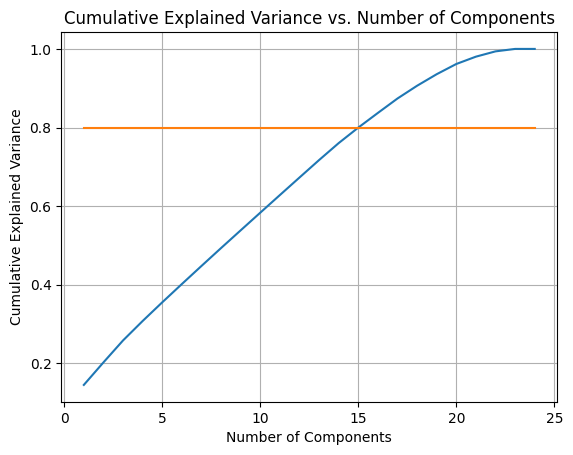

In [ ]:
# Find optimal number of components by plotting explained variance ratio vs number of components
x_ticks = np.arange(len(cum_evr)) + 1
plt.plot(size=[8, 6])
sns.lineplot(x = x_ticks, y = cum_evr)
sns.lineplot(x = x_ticks, y = 0.8 * np.ones(len(cum_evr)))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid()

plt.show()

From the plot, we have determined that the optimal number of components is 15. We now apply the PCA to the train and test data, specifying the number of components to keep.

In [ ]:
# Fit and transform on training data with n_components = 15
pca = PCA(n_components = 15)
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform on testing data
X_test_pca = pca.transform(X_test_scaled)

# Modeling

Now that we have our encoded, standardized, and independent input data, we can use it to train a linear regression model. Linear regression felt like a good place to start because we want to predict popularity, which is a continuous variable.

In [ ]:
# Fit linear regression model on PCA-transformed training data
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

# Predict on transformed test data using linear regression model
y_pred_lr = lr.predict(X_test_pca)

In [ ]:
# R^2 value calculations
lin_reg_score_test = lr.score(X_test_pca, y_test)
lin_reg_score_train = lr.score(X_train_pca, y_train)

# Evaluate the model using MSE
mse = mean_squared_error(y_test, y_pred_lr)

print('Test Set R^2 value: ' + str(lin_reg_score_test))
print('Training Set R^2 value: ' + str(lin_reg_score_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.05916711182576018
Training Set R^2 value: 0.05787028681260242
Mean Squared Error: 329.33401667252474


The R^2 values for our test set (\~0.0592) and our training set (\~0.0579) are similarly low, and this along with our mean squared error of \~329.33 suggests potential underfitting. We trained three more linear regression models, varying aspects of our input data:

**Linear regression using scaled instead of PCA-transformed data:** \\
Test Set R^2 value: 0.08990883760973856 \\
Training Set R^2 value: 0.08877878331943856 \\
Mean Squared Error: 318.57302377023586

**Linear regression using PCA-transformed data without songs with** `popularity` **= 0** \\
Test Set R^2 value: 0.07137533823290931 \\
Training Set R^2 value: 0.07268862126031994 \\
Mean Squared Error: 293.4206042745648

Both of these models performed marginally better. The improved performance of the first additional model indicates that we might be losing important information when applying PCA to our data; we could instead consider using Random Forest feature selection on our original dataset to determine the most important features for our prediction, then use Random Forest Regression, since its performance is not affected by multicollinearity. The improved performance of the second additional model suggests that the outlier songs with 0 popularity are impacting the performance of our model, as we predicted; we could address this simply by removing all songs with popularity 0.

# Feature Engineering & Data Preprocessing (Pt. 2)

We first remove all songs with popularity 0 from our input dataframe.

In [ ]:
# Drop all songs with popularity = 0
songs_input = songs_input[songs_input['popularity'] != 0]

## Create Training & Test Data

In this step, we split our new data (with only songs with popularity != 0) into training data and test data using an 80/20 split. For reproducibility, we fix randomness by setting our seed equal to 12345.

In [ ]:
# Split the data into training and testing sets with seed = 12345
seed = 12345;
X_train, X_test, y_train, y_test = train_test_split(songs_input.drop(columns=['popularity']), songs_input['popularity'], test_size=0.2,
                                                    random_state=seed, shuffle=True)

## Random Forest Feature Selection

Since our approach using PCA was not particularly successful and lacked explainability, in this step we use Random Forest Feature Selection to identify and keep only the most important features, reducing the dimensionality of our data. Since Random Forest is scale-invariant, we choose not to scale our data. For reproducibility, we fix randomness by setting our seed equal to 12345.

In [ ]:
# Fit Random Forest Regression model on training data
rf = RandomForestRegressor(n_estimators=200, max_depth=9, random_state=12345)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, n_estimators=200, random_state=12345)

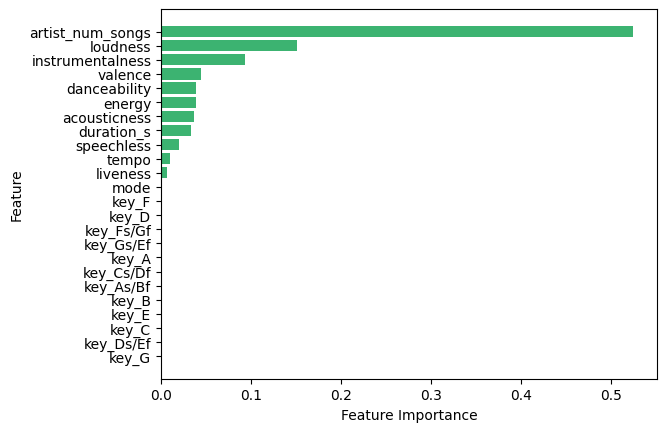

In [ ]:
# Create list of tuples (feature name, importance)
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechless', 'tempo', 'valence',
            'duration_s', 'artist_num_songs', 'key_A', 'key_As/Bf', 'key_B', 'key_C', 'key_Cs/Df', 'key_D', 'key_Ds/Ef', 'key_E', 'key_F',
            'key_Fs/Gf', 'key_G', 'key_Gs/Ef']
feature_importance = list(zip(features, rf.feature_importances_))
feature_importance.sort(key = lambda x : x[1])

# Plot feature importances in horizontal bar plot
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.barh([x[0] for x in feature_importance],[x[1] for x in feature_importance], color='mediumseagreen')

plt.show()

**Takeaway:** From the bar plot, we can see that `artist_num_songs` is the most important feature by a substantial margin, followed by `loudness`, then `instrumentalness`, and `valence`, `danceability`, `energy`, `acousticness`, `duration_s`, `speechiness`, `tempo`, and `liveness`. The least important features are the binary key columns and `mode` (also binary), which we drop.

In [ ]:
# Drop least important features from X_train
X_train = X_train[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
                   'duration_s', 'artist_num_songs']]
# Drop least important features from X_test
X_test = X_test[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
                           'duration_s', 'artist_num_songs']]

# Modeling (Pt. 2)

## Random Forest Regression

Now that we have kept only the most important features, we want to train a new model. Since our Linear Regression model seemed to suffer from underfitting, we want a more complex model that is able to capture the underlying patterns and relationships in our data. Decision trees seems suitable for this task, so we decide to use Random Forest Regression, which is built on decision trees.

In [ ]:
# Fit Random Forest Regression model on training data
rf = RandomForestRegressor(n_estimators=500, max_depth=12, random_state=12345)
rf.fit(X_train, y_train)

# Predict on train and test data
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

In [ ]:
# R^2 value calculations
rf_train = r2_score(y_train, y_pred_rf_train)
rf_test = r2_score(y_test, y_pred_rf_test)

# Evaluate the model using MSE
mse_rf = mean_squared_error(y_test, y_pred_rf_test)

print('Test Set R^2 value: ' + str(rf_test))
print('Training Set R^2 value: ' + str(rf_train))
print('Mean Squared Error: ' + str(mse_rf))

Test Set R^2 value: 0.27720486816655876
Training Set R^2 value: 0.34387041374245464
Mean Squared Error: 228.38396725939506


The Random Forest Regression model yields a relatively low R^2 value of \~0.277 for our test set and a relatively high R^2 value of \~0.344 for our training set. While this is an improvement from the linear regression model, the results now suggest slight overfitting, as our test error is higher than our training error.

We also tried running the model with the following parameters:
- n_estimators=100 & max_depth=8: yielded test R^2 value of \~0.21 and training R^2 value of \~0.22, indicating underfitting
- n_estimators=200 & max_depth=9: yielded test R^2 value of \~0.23 and training R^2 value of \~ 0.24, indicating underfitting
- n_estimators=300 & max_depth=11: yielded test R^2 value of \~0.26 and training R^2 value of \~0.30, indicating slight overfitting

## Gradient Boosting Regression

In order to improve our prediction accuracy, we decide to try Gradient Boosting Regression, which can be more accurate than random forests because each subsequent tree builds upon the results of the previous tree. Since Gradient Boosting Regression is scale-invariant, we choose not to scale our data.

In [ ]:
# Fit XGBRegressor model on training data
xgbr = XGBRegressor(eta=0.1, max_depth=12, seed=12345)
xgbr.fit(X_train, y_train)

# Predict on train and test data
y_pred_xgbr_test = xgbr.predict(X_test)
y_pred_xgbr_train = xgbr.predict(X_train)

In [ ]:
# Evaluate the model
r2_train = r2_score(y_train, y_pred_xgbr_train)
r2_test = r2_score(y_test, y_pred_xgbr_test)
mse_xgbr = mean_squared_error(y_test, y_pred_xgbr_test)

print('Test Set R^2 value: ' + str(r2_test))
print('Train Set R^2 value: ' + str(r2_train))
print('Mean Squared Error: ' + str(mse_xgbr))

Test Set R^2 value: 0.44661038370438755
Train Set R^2 value: 0.6931132532182824
Mean Squared Error: 174.85634648528628


### Hyperparameter Tuning

The Gradient Boosting Regression model performed noticeably better than the Random Forest Regression model, with a training R^2 value of \~0.693 and a test R^2 value of \~0.447. However, the results still suggest that the model is overfitting to the training data. Thus, we employ both `BayesianOptimization` and `GridSearchCV` to determine the optimal parameters for our model, using negative mean squared error as the scoring metric. The use of k-fold cross validation should mitigate the risk of overfitting by providing a more reliable assessment of the model's performance on new data.

In [ ]:
# Define the objective function to optimize
def objective(eta, max_depth):
    max_depth = int(max_depth)
    model = XGBRegressor(eta=eta, max_depth=max_depth, random_state=12345)
    # Perform cross-validation and return the negative mean squared error
    scores = -1.0 * cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return scores.mean()

In [ ]:
# Define the hyperparameter search space/grid
param_grid = {
    'eta': (0.01, 1),
    'max_depth': (3, 12)
}

# Initialize BayesianOptimization object + perform Bayesian optimization
optimizer = BayesianOptimization(f=objective, pbounds=param_grid, random_state=12345)
optimizer.maximize(init_points=5, n_iter=15)

# Print the best hyperparameters
best_hyperparameters = optimizer.max['params']
print("Best Hyperparameters:", best_hyperparameters)

|   iter    |  target   |    eta    | max_depth |
-------------------------------------------------
| 1         | 240.6     | 0.9303    | 5.847     |
| 2         | 239.7     | 0.1921    | 4.841     |
| 3         | 211.3     | 0.572     | 8.36      |
| 4         | 243.5     | 0.9649    | 8.879     |
| 5         | 221.8     | 0.7514    | 8.882     |
| 6         | 183.2     | 0.35      | 10.88     |
| 7         | 240.2     | 0.615     | 3.008     |
| 8         | 238.8     | 0.8863    | 6.581     |
| 9         | 244.0     | 0.9703    | 8.138     |
| 10        | 240.3     | 0.6152    | 3.008     |
| 11        | 240.6     | 0.7299    | 3.118     |
| 12        | 240.5     | 0.5273    | 3.177     |
| 13        | 248.2     | 1.0       | 7.944     |
| 14        | 232.5     | 0.8132    | 7.96      |
| 15        | 239.7     | 0.1006    | 5.233     |
| 16        | 245.3     | 0.9874    | 7.763     |
| 17        | 246.4     | 0.9928    | 7.519     |
| 18        | 230.8     | 0.7962    | 7.582     |


In [ ]:
# Fit XGBRegressor model with optimal hyperparameters determined via Bayesian Optimization
xgbr = XGBRegressor(eta=1.0, max_depth=8, seed=12345)
xgbr.fit(X_train, y_train)

# Predict on train and test data
y_pred_xgbr_test = xgbr.predict(X_test)
y_pred_xgbr_train = xgbr.predict(X_train)

In [ ]:
# Evaluate the model
r2_train = r2_score(y_train, y_pred_xgbr_train)
r2_test = r2_score(y_test, y_pred_xgbr_test)
mse_xgbr = mean_squared_error(y_test, y_pred_xgbr_test)

print('Test Set R^2 value: ' + str(r2_test))
print('Train Set R^2 value: ' + str(r2_train))
print('Mean Squared Error: ' + str(mse_xgbr))

Test Set R^2 value: 0.29018956057427614
Train Set R^2 value: 0.7133813057746489
Mean Squared Error: 224.28115107385275


The optimal hyperparameters determined via `BayesianOptimization` are eta=1.0 and max_depth=8. This model yields a training R^2 value of \~0.713 and a test R^2 value of \~0.290, indicating severe overfitting. Next, we try `GridSearchCV`:

In [ ]:
# Define the XGBRegressor model/estimator
estimator = XGBRegressor()

# Define the hyperparameter search space/grid
param_grid = {
    'eta': [0.01, 0.1, 1],
    'max_depth': [3, 6, 9, 12]
}

# Define the stratified cross-validation splitter
cv = StratifiedKFold(random_state=12345, shuffle=True, n_splits=5)

# Set up the grid search
search = GridSearchCV(estimator, param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=2)

# Execute the grid search
search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV] END ..............................eta=0.01, max_depth=3; total time=   3.6s
[CV] END ..............................eta=0.01, max_depth=3; total time=   0.9s
[CV] END ..............................eta=0.01, max_depth=3; total time=   0.8s
[CV] END ..............................eta=0.01, max_depth=3; total time=   0.8s
[CV] END ..............................eta=0.01, max_depth=3; total time=   0.8s
[CV] END ..............................eta=0.01, max_depth=6; total time=   1.6s
[CV] END ..............................eta=0.01, max_depth=6; total time=   1.6s
[CV] END ..............................eta=0.01, max_depth=6; total time=   1.7s
[CV] END ..............................eta=0.01, max_depth=6; total time=   3.4s
[CV] END ..............................eta=0.01, max_depth=6; total time=   2.8s
[CV] END ..............................eta=0.01, max_depth=9; total time=   4.2s
[CV] END ..............................eta=0.01, max_depth=9; total time=   4.3s
[CV] END ...................

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_t...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'eta': [0.01, 0.1, 1], 'max_depth': [3, 6, 9, 12]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Display best estimator
best_params = search.best_estimator_
print(best_params)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)


The optimal parameters determined via `GridSearchCV` end up being the parameters we originally chose: eta=0.1 and max_depth=12. Thus, the best XBGRegressor model within our hyperparameter search space has a training R^2 value of \~0.693 and a test R^2 value of \~0.447, and the lowest mean squared error we were able to achieve is \~174.9.

# Summary

## Approach/Methods

**Feature Engineering:** \\
To prepare for our modeling process, we one-hot encoded our categorical `key` column, scaled our data, and applied Principal Component Analysis (PCA) to account for multicollinearity, which we explored a bit in our EDA. We chose to apply PCA because linear regression assumes little to no multicollinearity in the data.

**Baseline Model:** \\
For our baseline model, linear regression seemed like a good choice because our target variable, `popularity`, is continuous. However, our R^2 values were relatively low (~0.06 for both training and test sets) and indicated underfitting, which is why we looked to more complex models in our next step. Training linear regression models on variations of our input data also shed some light on issues with our data, including noise from the overwhelming number of outlier songs with popularity=0 and suspected loss of information from applying PCA, both of which we addressed in our second feature engineering step.

**Feature Engineering cont.** \\
In our second feature engineering step, we dropped all songs with popularity=0 and created new training and test sets (without scaling or applying PCA). Since we were interested in what specific audio features contribute most to song popularity and our PCA approach lacked explainability, we implemented Random Forest Feature Selection and visualized the feature importances as a horizontal bar plot.

**Model #2** \\
We chose to implement Random Forest Regression as our second model in hopes of addressing the underfitting we had observed. Random Forest Regression, which is built on decision trees, is a more complex model that we thought might be able to capture the underlying patterns and relationships in our data. We used hyperparameters n_estimators=500 and max_depth=12; we chose relatively high values because we hoped to mitigate the risk of underfitting. Our Random Forest Regression model yielded a training R^2 value of \~0.34 and a test R^2 value of \~0.28, which was a noticeable improvement from our baseline model. However, the comparably high test error vs the comparably low training error suggested that our model was now beginning to overfit. To address this, we attempted to implement `GridSearchCV` and `BayesianOptimization`, but they were unable to execute in a reasonable amount of time, so we moved on to our next model instead.

**Model #3** \\
The third and final model we chose to implement was Gradient Boosting Regression. Aiming to improve both our training and test accuracy, we chose this model because it tends to be more powerful and accurate than Random Forest Regression due to its use of gradient descent; each subsequent tree builds upon the results of the previous tree. Our initial choice of hyperparameters was eta=0.1 and max_depth=12, which felt like a standard place to start. This yielded a training R^2 value of \~0.69 and a test R^2 value of \~0.45, which was an improvement from our Random Forest Regression model. However, since we were still observing overfitting, we decided to employ `GridSearchCV` and `BayesianOptimization`. The hyperparameters obtained via Bayesian optimization yielded an extremely overfitted model, while the hyperparameters were the same ones we originally chose (eta=0.1, max_depth=12). Thus, we determined that this was the best model within our hyperparameter search space, with a mean squared error of \~174.9.

## Results

Overall, Gradient Boosting Regression (with eta=0.1 and max_depth=12) performed the best, with the lowest mean squared error of \~174.9 and training and test R^2 values of \~0.69 and \~0.45, respectively. On the other hand, Linear Regression performed the worst, with a mean squared error of \~329.3 and training and test R^2 values of \~0.058 and \~0.060, respectively. Random Forest Regression performed better than Linear Regression but worse than Gradient Boosting Regression, with a mean squared error of \~228.4 and training and test R^2 values of \~0.34 and \~0.28, respectively. RFR and XGBoost likely performed better because they are more complex models built on decision trees, while LR is a simpler model. XGBoost likely performed the best because it utilizes gradient descent, building upon the results of each previous tree.

## Conclusion & Discussion

**Main Takeaways:**
- From our Random Forest Feature Selection step, we discovered that `artist_num_songs`, the number of times an artist appears in the dataset, was the most important feature in our Random Forest Regression model by a substantial margin. Following was `loudness`, then `instrumentalness`, and then `valence`, `danceability`, `energy`, `acousticness`, `duration_s`, `speechiness`, `tempo`, and `liveness`. From the bar plot we created, it seems that `mode` and the binary key columns had little to no importance in the model. This was somewhat surprising for us, as in our EDA we had computed a \~0.96 correlation value between song popularity and mean danceability, and we predicted that danceability would be extremely important due to the impact of social media. However, this data was collected in 2018 and 2019, which was just around the time when Tiktok first became popular; it would be interesting to collect more recent data and investigate whether danceability has become more important now, with the pervasiveness of Tiktok and Instagram reels.
- From our implementation of Linear Regression, we noticed that what most improved our model performance was cleaning the data, as well as using non PCA-transformed data. The outlier songs with popularity=0 seemed to be contributing noise and detracting from the performance of the model, and our use of PCA seemed to result in a loss of information that also hindered the performance of the model.
- Some limitations of Linear Regression that likely contributed to poor performance is the simplicity of the model. This resulted in underfitting, as the data was probably too complex for the model to capture. Limitations of Random Forest Regression include sensitivity to hyperparameters and tendency to overfit; since we were unable to do any hyperparameter tuning for this model, the hyperparameters we chose may not have been optimal, resulting in decreased performance. A limitation of Gradient Boosting Regression is also proneness to overfitting, which we saw even in our most optimal model.

**Implications:**
- Our work in this project provided some insight into what audio features contribute most to song popularity. While `artist_num_songs` might not be the most helpful feature (simply because it is due to the fact that artists with huge numbers of songs are mostly classical musicians who aren't popular with the average Spotify user), songwriters, producers, and stakeholders in music production companies may want to consider the fact that `loudness`, and `instrumentalness` are relatively important in predicting song popularity. On the other hand, features like `valence`, `danceability`, and `energy` all have values under \~0.05, making them relatively less important.
- Stakeholders at music production companies may also want to consider further research on this, as we have only tried a few models, and there is likely much more that can be learned.

**Future Work:**
- Use the Spotify API to collect more data and more recent data
- Collect data from other platforms (Apple Music, Billboard, Youtube Music, etc.)
- Join with a dataset that contains information about song release dates; it would be interesting to learn more about trends in acoustic features over time.
- Implement Recursive Feature Elimination with Random Forest Feature Selection to confirm which features are least important (and should be removed). We tried implementing this, but the execution was taking too long (> 1 hour).
- Implement hyperparameter tuning (`GridSearchCV`, `BayesianOptimization`, `RandomizedSearchCV`) for the Random Forest Regression model. We tried implementing this as well, but the execution was also taking too long.
- Experiment with neural networks to see if our training and test R^2 values can be improved and use regularization techniques to address the overfitting we've observed

**Sources**
- [Random Forest Feature Selection Tutorial](https://www.yourdatateacher.com/2021/10/11/feature-selection-with-random-forest/)
- [Example final project](https://colab.research.google.com/drive/1u1O5IVfcgPxvPljJTIi2klpscE74Iubj?usp=sharing#scrollTo=d4KGwL8KNI2C)
- Past homeworks (mainly HW4 and HW5) and recitation notebooks